In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from pathlib import Path
from scipy import ndimage, fft
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.utils import shuffle
import seaborn as sns

In [3]:
class LightFluxProcessor:

    def __init__(self, fourier=True, normalize=True, gaussian=True, standardize=True):
        self.fourier = fourier
        self.normalize = normalize
        self.gaussian = gaussian
        self.standardize = standardize

    def fourier_transform(self, X):
        return np.abs(np.fft.fft(X, n=X.size))

    def process(self, df_train_x, df_dev_x):
        if self.fourier:
            print("Applying Fourier...")
            df_train_x = np.apply_along_axis(self.fourier_transform, axis=1, arr=df_train_x)
            df_dev_x = np.apply_along_axis(self.fourier_transform, axis=1, arr=df_dev_x)

            df_train_x = df_train_x[:, :(df_train_x.shape[1] // 2)]
            df_dev_x = df_dev_x[:, :(df_dev_x.shape[1] // 2)]

        

        print("Finished Processing!")
        return df_train_x, df_dev_x

In [4]:
def np_X_Y_from_df(df):
    df = shuffle(df)
    df_X = df.drop(['LABEL'], axis=1)
    X = np.array(df_X)
    Y_raw = np.array(df['LABEL']).reshape((len(df['LABEL']),1))
    Y = Y_raw == 2
    return X, Y

Loading datasets...
Loaded datasets!
Applying Fourier...
Finished Processing!
Describing Datasets...
X_train.shape:  (5087, 1598)
Y_train.shape:  (5087, 1)
X_dev.shape:  (570, 1598)
Y_dev.shape:  (570, 1)
n_x:  1598
num_examples:  5087
n_y:  1
Training...


C:\Users\vikas\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\vikas\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


AUC training set: 0.552
AUC dev set: 0.237
 


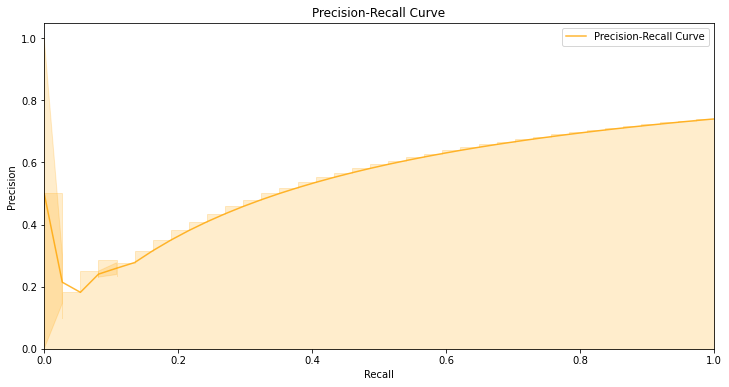

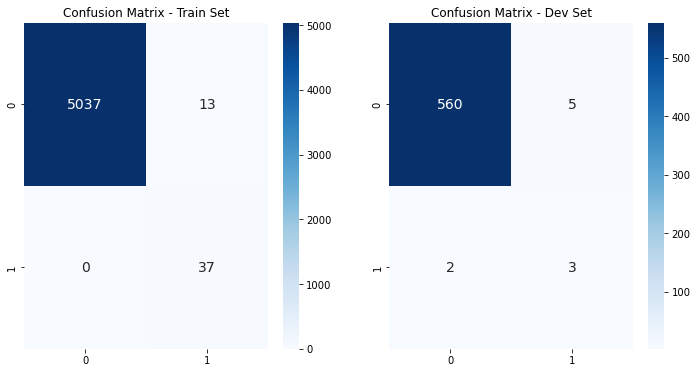

Classification Report - Train Set:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      5050
        True       0.74      1.00      0.85        37

    accuracy                           1.00      5087
   macro avg       0.87      1.00      0.92      5087
weighted avg       1.00      1.00      1.00      5087


Classification Report - Dev Set:
              precision    recall  f1-score   support

       False       1.00      0.99      0.99       565
        True       0.38      0.60      0.46         5

    accuracy                           0.99       570
   macro avg       0.69      0.80      0.73       570
weighted avg       0.99      0.99      0.99       570



In [6]:




def main():
    train_dataset_path = "Data/exoTrain.csv"
    dev_dataset_path = "Data/exoTest.csv"

    print("Loading datasets...")
    df_train = pd.read_csv(train_dataset_path, encoding="ISO-8859-1")
    df_dev = pd.read_csv(dev_dataset_path, encoding="ISO-8859-1")
    print("Loaded datasets!")


    df_train_x = df_train.drop('LABEL', axis=1)
    df_dev_x = df_dev.drop('LABEL', axis=1)
    df_train_y = df_train.LABEL
    df_dev_y = df_dev.LABEL
    LFP = LightFluxProcessor(
        fourier=True,
        normalize=False,
        gaussian=False,
        standardize=False)
    df_train_x, df_dev_x = LFP.process(df_train_x, df_dev_x)

    df_train_processed = pd.DataFrame(df_train_x).join(pd.DataFrame(df_train_y))
    df_dev_processed = pd.DataFrame(df_dev_x).join(pd.DataFrame(df_dev_y))

    X_train, Y_train = np_X_Y_from_df(df_train_processed)
    X_dev, Y_dev = np_X_Y_from_df(df_dev_processed)

    print("Describing Datasets...")
    (num_examples, n_x) = X_train.shape
    n_y = Y_train.shape[1]
    print("X_train.shape: ", X_train.shape)
    print("Y_train.shape: ", Y_train.shape)
    print("X_dev.shape: ", X_dev.shape)
    print("Y_dev.shape: ", Y_dev.shape)
    print("n_x: ", n_x)
    print("num_examples: ", num_examples)
    print("n_y: ", n_y)

    model = LinearSVC()

    X_train_sm, Y_train_sm = X_train, Y_train

    print("Training...")
    model.fit(X_train_sm, Y_train_sm)

    train_prob = model.decision_function(X_train)
    dev_prob = model.decision_function(X_dev)

    train_outputs = (train_prob > 0).astype(int)
    dev_outputs = (dev_prob > 0).astype(int)

    classification_report_train = classification_report(Y_train_sm, train_outputs)
    classification_report_dev = classification_report(Y_dev, dev_outputs)

    confusion_matrix_train = confusion_matrix(Y_train_sm, train_outputs)
    confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)

    ap_train = average_precision_score(Y_train_sm, train_prob)
    ap_dev = average_precision_score(Y_dev, dev_prob)
    
    print("AUC training set: %.3f" % ap_train)
    print("AUC dev set: %.3f" % ap_dev)
    print(" ")

    precision, recall, thresholds = precision_recall_curve(Y_train_sm, train_prob)
    plt.figure(figsize=(12, 6))

    sns.lineplot(x=recall, y=precision, color='orange', alpha=0.8, label='Precision-Recall Curve')
    plt.fill_between(recall, precision, alpha=0.2, color='orange', step='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix_train, annot=True, fmt='d', cmap='Blues', cbar=True, annot_kws={"size": 14})
    plt.title('Confusion Matrix - Train Set')

    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix_dev, annot=True, fmt='d', cmap='Blues', cbar=True, annot_kws={"size": 14})
    plt.title('Confusion Matrix - Dev Set')

    plt.show()

    print("Classification Report - Train Set:")
    print(classification_report_train)
    print("\nClassification Report - Dev Set:")
    print(classification_report_dev)

main()
